# got_hax

Back at it again with the white vans

we run the thing

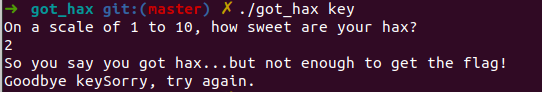

and it does indeed do something. 

also the contents of "key" is `dc26c7327afc46f26307ed69ff79c3d5`, which is the thing we care about that is encoded/encrypted

but enough of that, straight to ghidra

## looking through ghidra

we see right away an interesting function, named `get_your_flag`

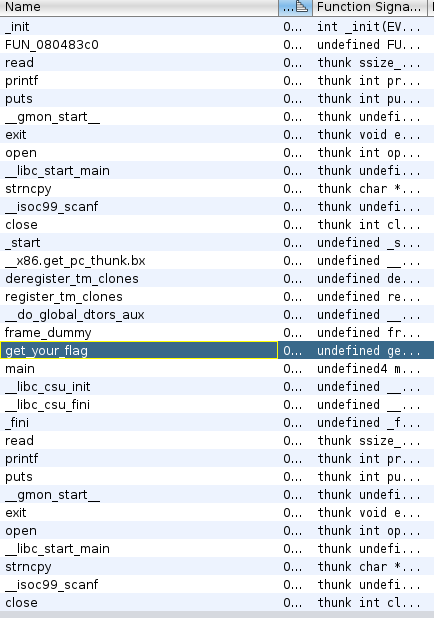

this looks promising, and might be something that we can use. regarless lets look at main

```C
int main(int argc,char **argv)

{
  uint local_3c;
  char local_38 [39];
  undefined local_11;
  int *local_10;
  
  local_10 = &argc;
  local_3c = 0;
  if (argc == 2) {
    puts("On a scale of 1 to 10, how sweet are your hax?");
    __isoc99_scanf("%u",&local_3c);
    if ((local_3c < 11) && (local_3c != 0)) {
      puts("So you say you got hax...but not enough to get the flag!");
      strncpy(local_38,argv[1],39);
      local_11 = 0;
      printf("Goodbye ");
      printf(local_38);
      puts("Sorry, try again.");
    }
    else {
      puts("Can you read? That\'s not even on the scale!");
    }
  }
  else {
    puts("Usage: ./got_hax [name]");
  }
  return 0;
}

void get_your_flag(void)

{
  int __fd;
  ssize_t sVar1;
  uint local_10;
  
  __fd = open("./key",0);
  local_10 = read(__fd,key,0x20);
  if (local_10 != 0xffffffff) {
    while (local_10 < 0x20) {
      sVar1 = read(__fd,key,0x20 - local_10);
      if (sVar1 != -1) {
        local_10 = local_10 + sVar1;
      }
    }
    close(__fd);
    key[32] = 0;
    printf("You GOT hax! Your flag is %s\n",key);
    return;
  }
                    /* WARNING: Subroutine does not return */
  exit(1);
}
```

basically it looks like we need to break normal execution from `main` (because none of the other functions look like they have anything interesting that we can touch), and get the execution flow to go to the `get_your_flag` function. so lets think about the things that we can write to, and the things that are read or execute dependent on the things that we can write to. 

`__isoc99_scanf("%u",&local_3c)` - this is generally uninteresting because we are limited to writing a max of 1 unsigned integer, so on its own this is not going to give us control of anything. additionally, there arent any interesting control flow checks on this value, so lets keep looking.
`strncpy(local_38,argv[1],39)` - this one has some promise, namely that it is writing 39 bytes to a 39 byte char array. this signals something potentially bad, because character arrays are generally used to hold strings (which terminate in a `0x00` byte), so we know if something reads from this location, that we will have the opportunity to get a string read out of bounds of the intended array

with these two write locations, i actually cant see anything specific that will break anything. 

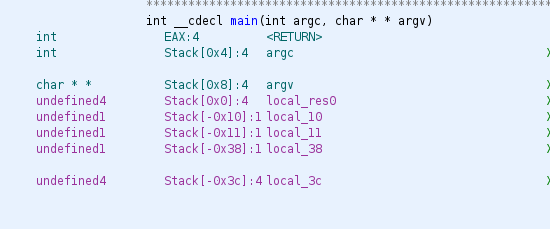

looking at ghidra's depiction of the stack, we see that we have the string `local_38` followed by `local_11`, which in the code we see is hardcoded to the value 0. this ends our dream of reading arbirtarily large strings from a single string pointer, but we continue. next we see `local_10`, which holds the address of `argc` on the stack. since ASLR is not enabled, our stack has consistient addresses, so we can know that given `local_10 = &argc` being the only assignment to `local_10`, that `local_10` will contain the value `0xffffcd70`. `local_3c` will contain the value (unsigned int) that we pass to the program. all of this implies our stack looks like the following (starting from low addresses to high):

\[arbitrary 4 byte int `local_3c`\]\[arbitrary 39 bytes (char) `local_38`\]\[0 (`local_11`)\]\[0xffffcd70 (`local_10`)\]

<figure>
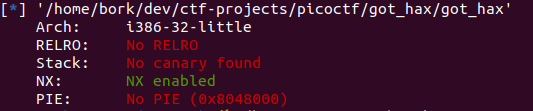
<figcaption align = "center"><b>got_hax file protections</b></figcaption>
</figure>

so as of right now, things still arent looking great, because we cant overwrite anything particularly useful in getting our control flow to change

## the evil `printf` 

one of the hints from the README mentions a printf looking sus. we know that because we are able to control the string being supplied to printf (`local_38`), that we have the ability to leak items off the stack (which is cool but not really needed right now), but what we need is to be able to write something useful. we are going to bet the farm on getting `%n` setup to write something useful 

but first, what are ways we can make 